In [1]:
import os
os.chdir('../')
print(f'Current Working Directory: {os.getcwd()}')

Current Working Directory: /Users/geovicco/Coding/Projects/deepgloberoadextraction


In [2]:
from dataclasses import dataclass
from pathlib import Path
from typing import List

@dataclass(frozen=True)

class TrainingConfig:
    # config.yaml
    models_dir: Path
    metadata_csv: Path
    logs_dir: Path
    # params.yaml
    architecture: str
    encoder: str
    encoder_weights: str
    num_classes: int
    num_channels: int
    epochs: int
    learning_rate: float
    batch_size: int
    precision: int
    device: str
    num_workers: int
    prefetch_factor: int
    resize_dimension: int
    checkpoint_path: Path
    encoder: str
    optimizer: str
    metrics: List[str]
    loss: str
    
from DeepGlobeRoadExtraction import CONFIG_FILE_PATH, PARAMS_FILE_PATH
from DeepGlobeRoadExtraction.utils.common import read_yaml

class ConfigurationManager:
    def __init__(self, config_filepath=CONFIG_FILE_PATH, params_filepath=PARAMS_FILE_PATH) -> None:
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
    
    def get_training_config(self) -> TrainingConfig:
        config = self.config.training
        params = self.params
        cfg = TrainingConfig(
            models_dir=Path(config.models_dir),
            metadata_csv=Path(config.metadata_csv),
            logs_dir=Path(config.logs_dir),
            architecture=params.architecture,
            encoder=params.encoder,
            encoder_weights=params.encoder_weights,
            num_classes=params.num_classes,
            num_channels=params.num_channels,
            epochs=params.epochs,
            learning_rate=params.learning_rate,
            batch_size=params.batch_size,
            precision=params.precision,
            device=params.device,
            num_workers=params.num_workers,
            prefetch_factor=params.prefetch_factor,
            resize_dimension=params.resize_dimension,
            checkpoint_path=None if params.checkpoint_path == 'None' else Path(params.checkpoint_path),
            optimizer=params.optimizer,
            metrics=params.metrics,
            loss=params.loss
            
        )
        return cfg
    
cfg = ConfigurationManager().get_training_config()

for k,v in cfg.__dict__.items():
    print(f"{k}: {v}")

[2024-06-15 22:59:03,925: INFO: common: yaml file: config.yaml loaded successfully]
[2024-06-15 22:59:03,928: INFO: common: yaml file: params.yaml loaded successfully]
models_dir: models
metadata_csv: data/metadataV2.csv
logs_dir: logs
architecture: PAN
encoder: resnet18
encoder_weights: imagenet
num_classes: 1
num_channels: 3
epochs: 25
learning_rate: 0.0001
batch_size: 6
precision: 16
device: auto
num_workers: 0
prefetch_factor: 6
resize_dimension: 512
checkpoint_path: None
optimizer: Adam
metrics: ['iou_score', 'f1_score', 'balanced_accuracy', 'precision', 'recall']
loss: FocalLoss


In [3]:
import torch
import albumentations as A
import cv2
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader

class RoadsDataset(torch.utils.data.Dataset):
    """DeepGlobe Road Extraction Challenge Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        df (pd.DataFrame): DataFrame containing images / labels paths
        split (str): Dataset split ('train', 'val', 'test')
        augmentation (albumentations.Compose): Data transformation pipeline (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): Data preprocessing (e.g. normalization, shape manipulation, etc.)
        resize_dimensions (int): Height and Width of transformed images
    """
    def __init__(
            self, 
            df: pd.DataFrame,
            split: str = 'train', 
            augmentation=None, 
            preprocessing=None,
            resize_dimensions: int = 256
    ):
        self.image_paths = df.loc[df['group'] == split, 'sat_image_path'].tolist()
        self.mask_paths = df.loc[df['group'] == split, 'mask_path'].tolist()
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.resize_dimensions = resize_dimensions
        
    @staticmethod
    def normalise_band(band):
        return (band - band.min()) / (band.max() - band.min())
        
    def __getitem__(self, i):
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        
        # Normalise image
        image = self.normalise_band(image)
        
        # Convert mask to grayscale
        mask = np.expand_dims(cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2GRAY), axis=-1)  # Convert mask to grayscale
        mask = np.where(mask==255, 1, mask)  # Map 255 to 1
                
        # Resize transform
        target_size = (self.resize_dimensions, self.resize_dimensions)
        resize_transform = A.Resize(*target_size, interpolation=cv2.INTER_LINEAR)
        transformed = resize_transform(image=image, mask=mask)
        image, mask = transformed['image'], transformed['mask']
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        # Convert mask to a tensor with the appropriate shape
        image = torch.tensor(image, dtype=torch.float).permute(2, 0, 1)  # (H, W, C) -> (C, H, W)
        mask = torch.tensor(mask, dtype=torch.long).permute(2, 0, 1)  # (H, W) -> (1, H, W)
        
        return image, mask
        
    def __len__(self):
        return len(self.image_paths)

# PyTorch Lightning Data Module
import pytorch_lightning as L

class RoadsDataModule(L.LightningDataModule):
    def __init__(self, metadata_csv, 
                 augmentation, preprocessing, batch_size, num_workers, resize_dimensions):
        super().__init__()
        self.metadata = pd.read_csv(metadata_csv)
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.resize_dimensions = resize_dimensions
        
    def setup(self, stage: str = None) -> None:
        if stage == 'fit' or stage is None:
            self.train_dataset = RoadsDataset(
                df=self.metadata, split='train',
                augmentation=self.augmentation,
                preprocessing=self.preprocessing,
                resize_dimensions=self.resize_dimensions
            )
            self.val_dataset = RoadsDataset(
                df=self.metadata, split='val',
                preprocessing=self.preprocessing,
                resize_dimensions=self.resize_dimensions
            )
        if stage == 'test':
            self.test_dataset = RoadsDataset(
                df=self.metadata, split='test',
                preprocessing=self.preprocessing,
                resize_dimensions=self.resize_dimensions
            )
            
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, drop_last=False, num_workers=self.num_workers)
        
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, drop_last=False, num_workers=self.num_workers)
    
##### Data Augmentation #####
def get_training_augmentation():
    train_transform = [
        A.HorizontalFlip(p=0.5),  # horizontal flip
        A.VerticalFlip(p=0.5),  # vertical flip
        A.Rotate(limit=90),  # 90 degree rotation
        A.RandomGamma(p=0.2),  # random gamma
        # A.GaussNoise(p=0.2),  # gaussian noise
        A.RandomBrightnessContrast(p=0.2),  # random brightness and contrast,
    ]
    return A.Compose(train_transform)

In [4]:
import segmentation_models_pytorch as sm_torch

def to_tensor(x, **kwargs):
    return x.transpose(0, 1, 2).astype('float32')
    
def get_preprocessing_function(encoder, weights):
    preprocessing_function = sm_torch.encoders.get_preprocessing_fn(encoder, weights)
    return preprocessing_function

def get_preprocessing(preprocessing_fn=None):  
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(A.Lambda(image=preprocessing_fn))
    _transform.append(A.Lambda(image=to_tensor, mask=to_tensor))
        
    return A.Compose(_transform)

In [5]:
dm = RoadsDataModule(
    metadata_csv=cfg.metadata_csv,
    augmentation=get_training_augmentation(),
    preprocessing=None, 
    # preprocessing=get_preprocessing(get_preprocessing_function(cfg.encoder, cfg.encoder_weights)),
    batch_size=cfg.batch_size,
    num_workers=cfg.num_workers,
    resize_dimensions=cfg.resize_dimension
)

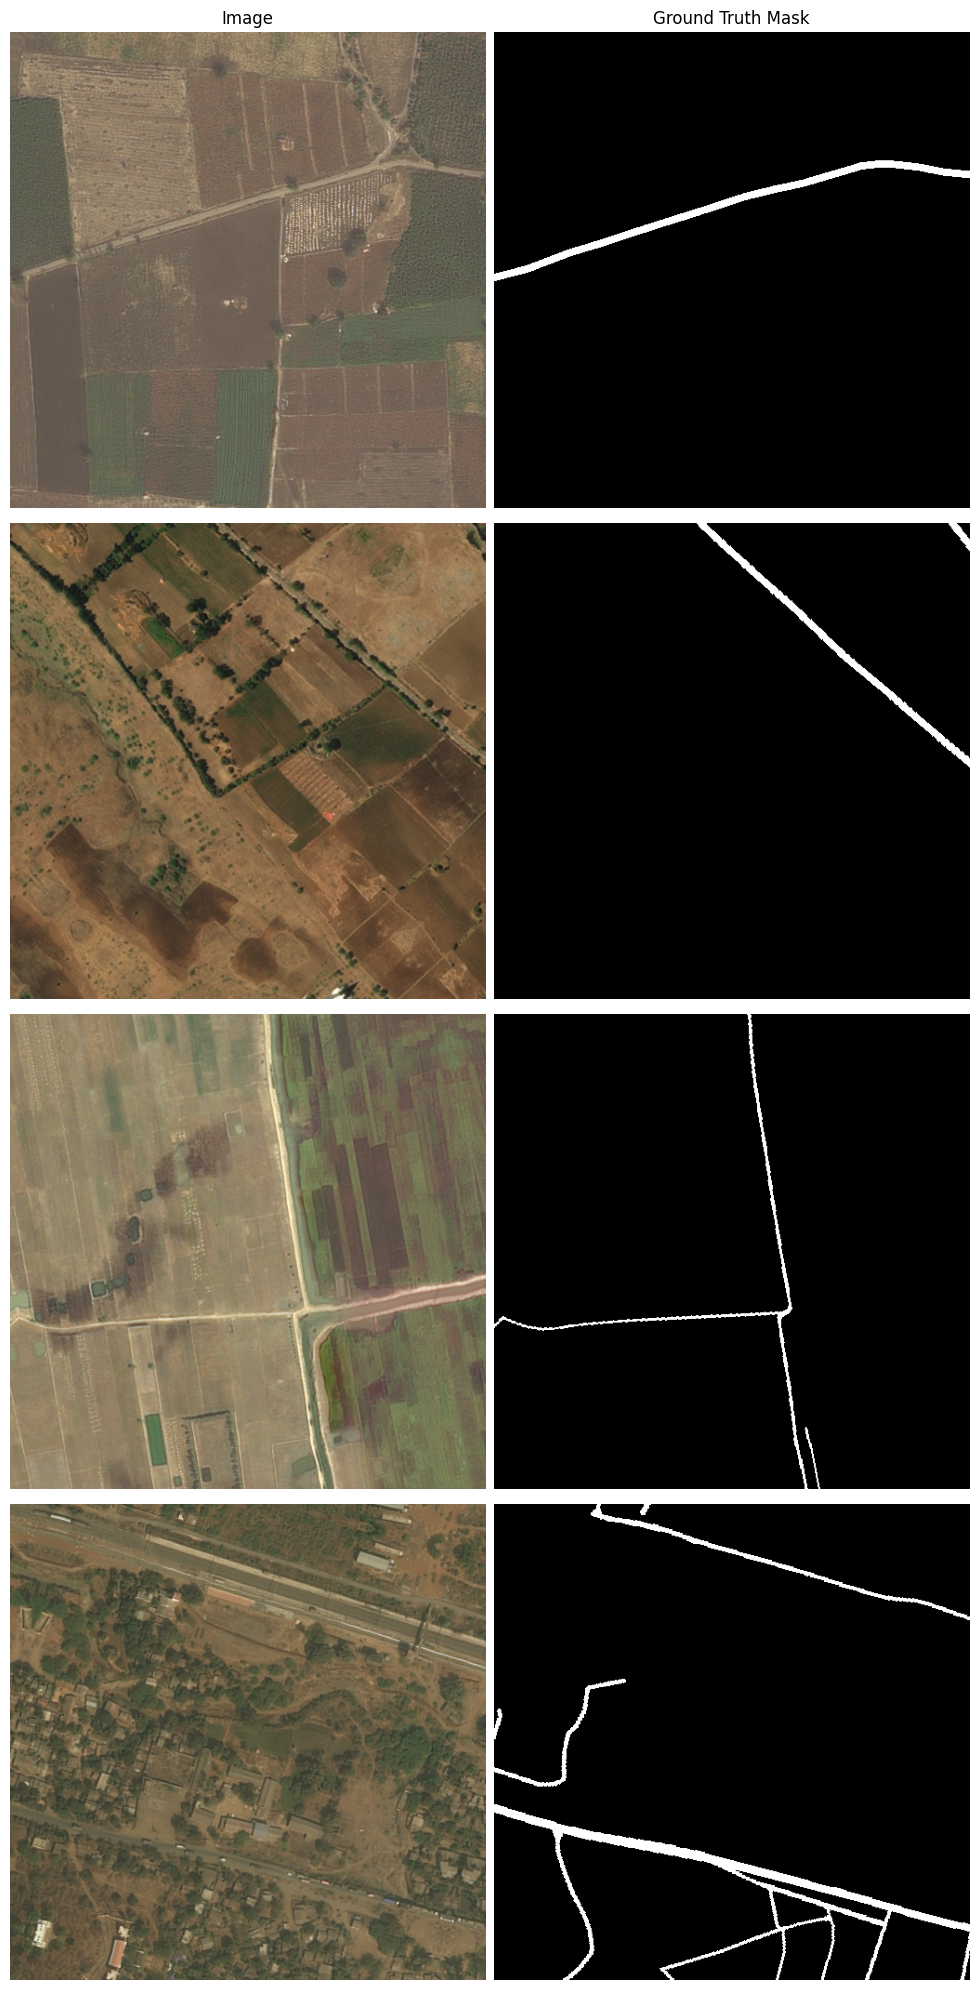

In [6]:
# Plot sample from the training dataset
import matplotlib.pyplot as plt
import numpy as np
import warnings; warnings.filterwarnings('ignore')

dm.setup('fit')

n_samples = 4

# Get the train dataloader
dataloader = dm.train_dataloader()

# Randomly select a batch of data
x, y = next(iter(dataloader))

# Plot the results
fig, axs = plt.subplots(n_samples, 2, figsize=(10, n_samples*5))
for i in range(n_samples):
    # Plot the image
    image = x[i].cpu().numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
    # Get Vmin and Vmax as 2nd and 98th percentile
    vmin = np.percentile(image, 2)
    vmax = np.percentile(image, 98)
    axs[i, 0].imshow(image, vmin=vmin, vmax=vmax)
    axs[i, 0].axis('off')
    if i == 0:
        axs[i, 0].set_title('Image')
    
    # Plot the ground truth mask
    ground_truth_mask = y[i].cpu().numpy().squeeze()  # (1, H, W) -> (H, W)
    axs[i, 1].imshow(ground_truth_mask, cmap='binary_r')
    axs[i, 1].axis('off')
    if i == 0:
        axs[i, 1].set_title('Ground Truth Mask')

plt.tight_layout()
plt.show()

In [7]:
x.shape, y.shape, x[0].min(), x[0].max(), y[0].min(), y[0].max()

(torch.Size([6, 3, 512, 512]),
 torch.Size([6, 1, 512, 512]),
 tensor(0.1820),
 tensor(0.9593),
 tensor(0),
 tensor(1))

In [8]:
import pytorch_lightning as pl
import torchmetrics
from torch.optim.lr_scheduler import ReduceLROnPlateau
from segmentation_models_pytorch import utils

class Model(pl.LightningModule):
    def __init__(self, architecture, n_channels, n_classes, lr, encoder, encoder_weights, loss):
        super().__init__()
        self.save_hyperparameters() # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.lr = lr
        self.architecture = architecture
        self.encoder = encoder
        self.encoder_weights = encoder_weights
        self.loss = loss
        
        self.model_dict = {
            'Unet': sm_torch.Unet,
            'DeepLabV3Plus': sm_torch.DeepLabV3Plus,
            'DeepLabV3': sm_torch.DeepLabV3,
            'UnetPlusPlus': sm_torch.UnetPlusPlus,
            'Linknet': sm_torch.Linknet,
            'PSPNet': sm_torch.PSPNet,
            'FPN': sm_torch.FPN,
            'MAnet': sm_torch.MAnet,
            'PAN': sm_torch.PAN
        }
        
        sm_torch.losses.constants.BINARY_MODE = True
        
        self.loss_dict = {
            'DiceLoss': sm_torch.losses.DiceLoss,
            'FocalLoss': sm_torch.losses.FocalLoss,
            'TverskyLoss': sm_torch.losses.TverskyLoss,
            'JaccardLoss': sm_torch.losses.JaccardLoss,
            'LovaszLoss': sm_torch.losses.LovaszLoss,
            'SoftBCEWithLogitsLoss': sm_torch.losses.SoftBCEWithLogitsLoss,
            'SoftCrossEntropyLoss': sm_torch.losses.SoftCrossEntropyLoss,
            'MCCLoss': sm_torch.losses.MCCLoss
            
        }
        
        # Initialize model
        self.model = self.model_dict[self.architecture](encoder_name=self.encoder, encoder_weights=self.encoder_weights, in_channels=self.n_channels, classes=self.n_classes)
        
        # self.model = sm_torch.DeepLabV3Plus(encoder_weights=self.encoder_weights, encoder_name=self.encoder, in_channels=self.n_channels, classes=self.n_classes)
        # self.model = sm_torch.Unet(encoder_name=self.encoder, encoder_weights=self.encoder_weights, in_channels=self.n_channels, classes=self.n_classes)
        
        # Loss function
        # self.loss_fn = utils.losses.DiceLoss()
        if self.loss in ['DiceLoss', 'FocalLoss', 'TverskyLoss', 'JaccardLoss', 'LovaszLoss']:
            self.loss_fn = self.loss_dict[self.loss](mode='binary')
        else:
            self.loss_fn = self.loss_dict[self.loss]()

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch  # x is the input image and y is the corresponding segmentation mask
        y_hat = self(x)  # Forward pass
        loss = self.loss_fn(y_hat, y)  # Compute loss
        
        tp, fp, fn, tn = sm_torch.metrics.get_stats(y_hat, y, mode='binary', threshold=0.5)
        
        iou_score = sm_torch.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        f1_score = sm_torch.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
        f2_score = sm_torch.metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="micro")
        accuracy = sm_torch.metrics.balanced_accuracy(tp, fp, fn, tn, reduction="macro")
        recall = sm_torch.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")
        precision = sm_torch.metrics.precision(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # y_hat_argmax = (torch.sigmoid(y_hat) > 0.5).float()  # Apply sigmoid and threshold at 0.5
        
        # self.precision = torchmetrics.Precision(task="binary", threshold=0.5)
        # self.recall = torchmetrics.Recall(task="binary", threshold=0.5)
        # self.f1 = torchmetrics.F1Score(task="binary", threshold=0.5)
        # self.jaccard = torchmetrics.JaccardIndex(task="binary", threshold=0.5)

        # # Torch metric
        # tm_rec = self.recall(y_hat_argmax, y)
        # tm_prec = self.precision(y_hat_argmax, y)
        # tm_iou = self.jaccard(y_hat_argmax, y)
        # tm_f1 = self.f1(y_hat_argmax, y)

        self.log_dict({
            "train_loss": loss,
            "train_iou": iou_score,
            "train_f1": f1_score,
            "train_f2": f2_score,
            "train_accuracy": accuracy,
            "train_precision": precision,
            "train_recall": recall,
        }, prog_bar=True, on_step=False, on_epoch=True)
        
        # log values
        if self.logger:
            self.logger.experiment.add_scalar('Train/F1Score', f1_score, self.global_step)
            self.logger.experiment.add_scalar('Train/F2Score', f2_score, self.global_step)
            self.logger.experiment.add_scalar('Train/IoU', iou_score, self.global_step)
            self.logger.experiment.add_scalar('Train/Recall', recall, self.global_step)
            self.logger.experiment.add_scalar('Train/Precision', precision, self.global_step)
            self.logger.experiment.add_scalar('Train/BalancedAccuracy', accuracy, self.global_step)
            self.logger.experiment.add_scalar('Train/Loss', loss, self.global_step)
            self.logger.experiment.add_scalar('Train/LearningRate', self.lr, self.global_step)

        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)  # Compute loss
        
        tp, fp, fn, tn = sm_torch.metrics.get_stats(y_hat, y, mode='binary', threshold=0.5)
        
        iou_score = sm_torch.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        f1_score = sm_torch.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
        f2_score = sm_torch.metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="micro")
        accuracy = sm_torch.metrics.balanced_accuracy(tp, fp, fn, tn, reduction="macro")
        recall = sm_torch.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")
        precision = sm_torch.metrics.precision(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # y_hat_argmax = (torch.sigmoid(y_hat) > 0.5).float()  # Apply sigmoid and threshold at 0.5

        # Torch metric
        # tm_rec = self.recall(y_hat_argmax,y)
        # tm_prec = self.precision(y_hat_argmax,y)
        # tm_iou = self.jaccard(y_hat_argmax,y)
        # tm_f1 = self.f1(y_hat_argmax,y)
        
        # log_dict = {
        #     "val_loss":loss,
        #     "val_iou":tm_iou,
        #     "val_f1":tm_f1,
        #     "val_precision":tm_prec,
        #     "val_recall":tm_rec,
        # }
        
        # self.log_dict(log_dict, prog_bar=True, on_step=False, on_epoch=True)
        
        # if self.logger:
        #     self.logger.experiment.add_scalar('Valid/F1Score', tm_f1, self.global_step)
        #     self.logger.experiment.add_scalar('Valid/IoU', tm_iou, self.global_step)
        #     self.logger.experiment.add_scalar('Valid/Recall', tm_rec, self.global_step)
        #     self.logger.experiment.add_scalar('Valid/Precision', tm_prec, self.global_step)
        #     self.logger.experiment.add_scalar('Valid/Loss', loss, self.global_step)
        
        self.log_dict({
            "val_loss": loss,
            "val_iou": iou_score,
            "val_f1": f1_score,
            "val_f2": f2_score,
            "val_accuracy": accuracy,
            "val_precision": precision,
            "val_recall": recall,
        }, prog_bar=True, on_step=False, on_epoch=True)
        
        # log values
        if self.logger:
            self.logger.experiment.add_scalar('Validation/F1Score', f1_score, self.global_step)
            self.logger.experiment.add_scalar('Validation/F2Score', f2_score, self.global_step)
            self.logger.experiment.add_scalar('Validation/IoU', iou_score, self.global_step)
            self.logger.experiment.add_scalar('Validation/Recall', recall, self.global_step)
            self.logger.experiment.add_scalar('Validation/Precision', precision, self.global_step)
            self.logger.experiment.add_scalar('Validation/BalancedAccuracy', accuracy, self.global_step)
            self.logger.experiment.add_scalar('Validation/Loss', loss, self.global_step)
            self.logger.experiment.add_scalar('Validation/LearningRate', self.lr, self.global_step)
        
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        y_hat_argmax = (torch.sigmoid(y_hat) > 0.5).float()  # Apply sigmoid and threshold at 0.5

        # Torch metric
        tm_rec = self.recall(y_hat_argmax,y)
        tm_prec = self.precision(y_hat_argmax,y)
        tm_iou = self.jaccard(y_hat_argmax,y)
        tm_f1 = self.f1(y_hat_argmax,y)
        
        log_dict = {
            "test_loss":loss,
            "test_iou":tm_iou,
            "test_f1":tm_f1,
            "test_precision":tm_prec,
            "test_recall":tm_rec,
        }
        
        self.log_dict(log_dict, prog_bar=True, on_step=False, on_epoch=True)
        
        return log_dict
    
    def on_validation_epoch_end(self):
        metrics = self.trainer.logged_metrics

        # Ensure metrics are iterable before attempting to stack them
        mean_outputs = {}
        for k, v in metrics.items():
            if isinstance(v, torch.Tensor) and v.dim() == 0:
                mean_outputs[k] = v  # Use the scalar value directly
            elif isinstance(v, list) and all(isinstance(i, torch.Tensor) for i in v):
                mean_outputs[k] = torch.stack(v).mean()  # Calculate the mean if it's a list of tensors
            else:
                mean_outputs[k] = torch.tensor(v).mean()  # Default case, convert to tensor and calculate mean

        # Log the mean metrics
        self.log_dict(mean_outputs, prog_bar=True)
        
    # def configure_optimizers(self):
    #     opt = torch.optim.Adam(self.parameters(), lr=self.lr)
    #     sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)
    #     return [opt], [sch]
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        lr_scheduler = {
            'scheduler': ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True),
            'monitor': 'val_loss'
        }
        return [optimizer], [lr_scheduler]

In [9]:
model = Model(
    architecture=cfg.architecture, 
    n_channels=cfg.num_channels, 
    n_classes=cfg.num_classes, 
    lr=cfg.learning_rate, 
    encoder=cfg.encoder, 
    encoder_weights=cfg.encoder_weights,
    loss = 'DiceLoss'
)
model

Model(
  (model): PAN(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2

In [10]:
# Trainer
import pytorch_lightning as pl
import torch
torch.set_float32_matmul_precision('medium')

trainer = pl.Trainer(
    accelerator=cfg.device, 
    max_epochs=cfg.epochs, 
    # precision='16-mixed', 
    logger=None,
    # callbacks=[early_stopping, checkpoint_callback, lr_monitor],
    enable_progress_bar=True,
    fast_dev_run=False
)

[2024-06-15 22:59:09,696: INFO: rank_zero: GPU available: True (mps), used: True]
[2024-06-15 22:59:09,697: INFO: rank_zero: TPU available: False, using: 0 TPU cores]
[2024-06-15 22:59:09,697: INFO: rank_zero: IPU available: False, using: 0 IPUs]
[2024-06-15 22:59:09,698: INFO: rank_zero: HPU available: False, using: 0 HPUs]


In [11]:
import warnings; warnings.filterwarnings('ignore')
dm.setup('fit')
trainer.fit(model=model, train_dataloaders=dm.train_dataloader(), val_dataloaders=dm.val_dataloader())

[2024-06-15 22:59:09,807: INFO: model_summary: 
  | Name    | Type     | Params
-------------------------------------
0 | model   | PAN      | 11.4 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.471    Total estimated model params size (MB)]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]